In [4]:
import os
import torch
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor

In [5]:
#train data = td
td = ImageFolder('data/train', transform=ToTensor())
#validation data = vd
vd = ImageFolder('data/valid', transform=ToTensor())
print(os.listdir('data'))
print(len(td))

classes = td.classes
print(classes)

['valid', '.DS_Store', 'test', 'train', 'car parts.csv']
8739
['AIR COMPRESSOR', 'ALTERNATOR', 'BATTERY', 'BRAKE CALIPER', 'BRAKE PAD', 'BRAKE ROTOR', 'CAMSHAFT', 'CARBERATOR', 'CLUTCH PLATE', 'COIL SPRING', 'CRANKSHAFT', 'CYLINDER HEAD', 'DISTRIBUTOR', 'ENGINE BLOCK', 'ENGINE VALVE', 'FUEL INJECTOR', 'FUSE BOX', 'GAS CAP', 'HEADLIGHTS', 'IDLER ARM', 'IGNITION COIL', 'INSTRUMENT CLUSTER', 'LEAF SPRING', 'LOWER CONTROL ARM', 'MUFFLER', 'OIL FILTER', 'OIL PAN', 'OIL PRESSURE SENSOR', 'OVERFLOW TANK', 'OXYGEN SENSOR', 'PISTON', 'PRESSURE PLATE', 'RADIATOR', 'RADIATOR FAN', 'RADIATOR HOSE', 'RADIO', 'RIM', 'SHIFT KNOB', 'SIDE MIRROR', 'SPARK PLUG', 'SPOILER', 'STARTER', 'TAILLIGHTS', 'THERMOSTAT', 'TORQUE CONVERTER', 'TRANSMISSION', 'VACUUM BRAKE BOOSTER', 'VALVE LIFTER', 'WATER PUMP', 'WINDOW REGULATOR']


In [6]:
piston_files = os.listdir('data/train/PISTON')
print('Number of training examples for pistons is ', len(piston_files))
print(piston_files[:3])

Number of training examples for pistons is  113
['016.jpg', '002.jpg', '003.jpg']


In [7]:
piston_test_files = os.listdir('data/test/PISTON')
print('Number of testing examples for pistons is ', len(piston_test_files))
print(piston_test_files[:3])

Number of testing examples for pistons is  5
['4.jpg', '5.jpg', '2.jpg']


In [8]:
img, label = td[0]
print(img.shape, label)
img

torch.Size([3, 224, 224]) 0


tensor([[[0.1647, 0.1882, 0.2000,  ..., 0.3255, 0.3294, 0.3255],
         [0.1843, 0.2078, 0.2196,  ..., 0.3294, 0.3294, 0.3255],
         [0.1922, 0.2196, 0.2314,  ..., 0.3451, 0.3373, 0.3294],
         ...,
         [0.4353, 0.4314, 0.4235,  ..., 0.3451, 0.3490, 0.3608],
         [0.4431, 0.4353, 0.4235,  ..., 0.3059, 0.3176, 0.3373],
         [0.4235, 0.4157, 0.4039,  ..., 0.2667, 0.2745, 0.2902]],

        [[0.1882, 0.2118, 0.2235,  ..., 0.3804, 0.3765, 0.3725],
         [0.2078, 0.2314, 0.2431,  ..., 0.3843, 0.3765, 0.3725],
         [0.2157, 0.2431, 0.2549,  ..., 0.3882, 0.3765, 0.3686],
         ...,
         [0.5020, 0.4980, 0.4902,  ..., 0.4000, 0.4039, 0.4157],
         [0.5098, 0.5020, 0.4902,  ..., 0.3608, 0.3725, 0.3922],
         [0.4902, 0.4824, 0.4706,  ..., 0.3216, 0.3294, 0.3451]],

        [[0.1804, 0.2039, 0.2157,  ..., 0.3843, 0.3765, 0.3725],
         [0.2000, 0.2235, 0.2353,  ..., 0.3882, 0.3765, 0.3725],
         [0.2078, 0.2353, 0.2471,  ..., 0.3961, 0.3804, 0.

In [9]:
import matplotlib
import matplotlib.pyplot as plt

matplotlib.rcParams['figure.facecolor'] = '#ffffff'

In [10]:
def visualize_ex(img, label):
    print('label: ', td.classes[label], '('+str(label)+')')
    plt.imshow(img.permute(1, 2, 0))
    

label:  AIR COMPRESSOR (0)


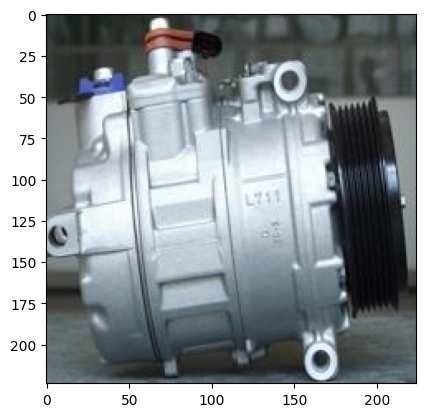

In [11]:
visualize_ex(*td[0])

label:  OIL PAN (26)


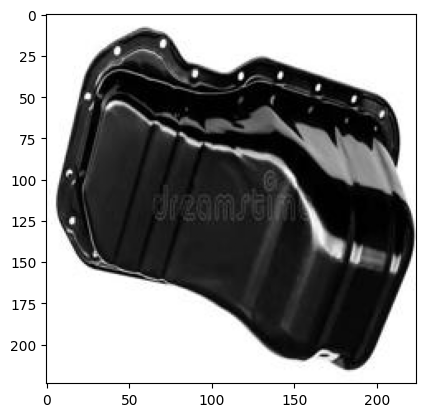

In [12]:
visualize_ex(*td[4600])

In [13]:
from torch.utils.data.dataloader import DataLoader

batch_size = 32

In [14]:
train_d = DataLoader(td, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_d = DataLoader(vd, batch_size*2, shuffle=True, num_workers=4, pin_memory=True)
len(train_d), len(val_d)

(274, 4)

In [15]:
from torchvision.utils import make_grid

In [16]:
def visualize_batch(dl):
    for images, labels in dl:
        fix, ax = plt.subplots(figsize=(12,6))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
        break

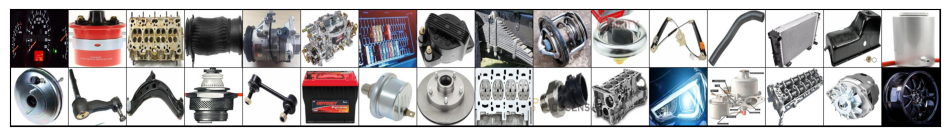

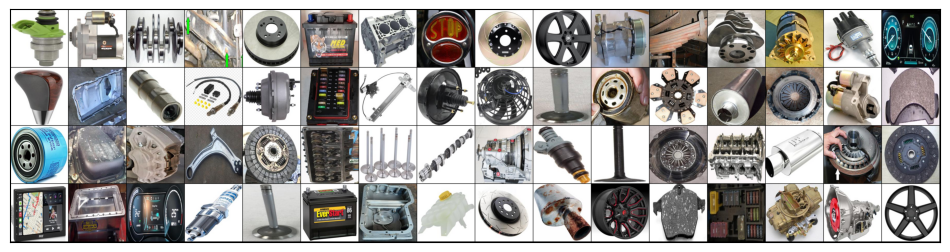

In [17]:
visualize_batch(train_d)
visualize_batch(val_d)

In [19]:
import torch.nn as nn
import torch.nn.functional as F

In [21]:
class ClassifyImagesSub(nn.Module):
    def t_step(self, batch):
        images, labels = batch
        output = self(images)
        loss = F.cross_entropy(output, labels)
        return loss
    def v_step(self, batch):
        images, labels = batch
        output = self(images)
        loss = F.cross_entropy(output, labels)
        rate = rate(output, labels)
        return {'val_loss':loss.detach(), 'val_rate:': rate}
    def epoch_losses(self, outputs):
        b_losses = [x['val_loss'] for x in outputs]
        e_losses = torch.stack(b_losses).mean()
        b_rate = [x['val_acc'] for x in outputs]
        e_rate = torch.stack(b_rate).mean()
        return {'val_loss': e_losses.items(), 'val_rate': e_rate.item()}
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_rate: {:.4f}".format
              (epoch, result['train_loss'], result['val_loss', result['val_rate']]))
    def accuracy(outputs, labels):
        _, preds = torch.max(outputs, dim=1)
        return torch.tensor(torch.sum(preds == labels).item()/len(preds))

In [22]:
class CarPartCNN(ClassifyImagesSub):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            # img --> 3(channels) x 224 x 224
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            # 32 x 224 x 224
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            # 64 x 224 x 224
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # 64 x 112 x 112
            
            
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # 128 x 56 x 56
            
            
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # 256 x 28 x 28
            
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # 512 x 14 x 14
        
        
            nn.Flatten(),
            nn.Linear(512*14*14, 7168),
            nn.ReLU(),
            nn.Linear(7168, 3584),
            nn.ReLU(),
            nn.Linear(3584, 896),
            nn.ReLU(),
            nn.Linear(896, 224),
            nn.ReLU(),
            nn.Linear(224, 50))
        
    def forward(self, xb):
        return self.network(xb)

In [23]:
model = CarPartCNN()
model

CarPartCNN(
  (network): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (16): ReLU()
    (17): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1

In [24]:
for imgs, lbls in train_d:
    print('images_shape: ', imgs.shape)
    out = model(imgs)
    print('out_shape: ', out.shape)
    print('out[0]: ', out[0])
    break

images_shape:  torch.Size([32, 3, 224, 224])
out_shape:  torch.Size([32, 50])
out[0]:  tensor([ 0.0137,  0.0335, -0.0310, -0.0495, -0.0307, -0.0282,  0.0147,  0.0525,
        -0.0034,  0.0046, -0.0496,  0.0484, -0.0639,  0.0547,  0.0211, -0.0433,
         0.0130, -0.0007,  0.0596,  0.0531, -0.0364,  0.0212, -0.0008, -0.0585,
         0.0078, -0.0381, -0.0063,  0.0354,  0.0219, -0.0306, -0.0010, -0.0016,
        -0.0453,  0.0312,  0.0469, -0.0425,  0.0217, -0.0438,  0.0616, -0.0411,
        -0.0666,  0.0182,  0.0474, -0.0090,  0.0746, -0.0223,  0.0563,  0.0206,
        -0.0447,  0.0031], grad_fn=<SelectBackward0>)
